In [3]:
# import all the necessary libraries
# import basic libraries
import numpy as np
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

# import basic libraries for time series analysis
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

# import models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR,ARResults #AR model
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults #ARIMAモデル
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

# import advanced methods of time series analysis
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [9]:
# USA = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/FYP_USA.csv",index_col= "TIme",header = 0, parse_dates = True)
# USA.index.freq = "YS"
# USA.columns

# import datasets gained from FRED-MD
data = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/current.csv",index_col = "sasdate",header = 0,parse_dates = True)
data.index.freq = "MS"
#pull the transformation code and save it in a dictionary to adjust data for later analysis.
transformation_code = {key: val for key, val in zip(data.loc["Transform:"].index,data.loc["Transform:"].values)}

# making a new data and delete the transformation code
USA = data.copy()
USA = USA.loc["11/1/2011":"12/1/2019"].dropna()
USA.index.freq = "MS"
data.head()

# change the data as expected in the FRED-MD
df = adjust_data(USA,transformation_code)
#dfs = 
# conduct augmented Dickey-Fuller test just in case.
weak_stationary = []
for col in roop_adf(df):
    weak_stationary.append(f"{col} {transformation_code[col]}")

Augumented Dickey-Fuller Test:
ADS test statistic     -1.051113e+01
p-value                 1.023852e-18
# lags used             0.000000e+00
# observations          9.500000e+01
Critical Value (1%)    -3.501137e+00
Critical Value (5%)    -2.892480e+00
Critical Value (10%)   -2.583275e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augumented Dickey-Fuller Test:
ADS test statistic     -1.067614e+01
p-value                 4.049251e-19
# lags used             0.000000e+00
# observations          9.500000e+01
Critical Value (1%)    -3.501137e+00
Critical Value (5%)    -2.892480e+00
Critical Value (10%)   -2.583275e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augumented Dickey-Fuller Test:
ADS test statistic     -1.293694e+01
p-value                 3.601400e-24
# lags used             0.000000e+00
# observations          9.500000e+01
Critical Value (1%)

In [10]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
data_matrix = grangers_causation_matrix(df.dropna(),variables=USA.columns)

In [11]:
selected_variables = []
for idx, val,ycol,yval in zip(data_matrix["S&P 500_x"].index,data_matrix["S&P 500_x"].values,data_matrix.loc["S&P 500_y"].index,data_matrix.loc["S&P 500_y"].values):
    if val != False and yval != False:
        selected_variables.append(idx[:-2])
print(selected_variables)

data_matrix.loc["S&P 500_y"]
# Extract variables' name, only if they affect S&P500
sp500_list = []
for col,val in data_matrix.loc["S&P 500_y"].items():
    if val != False:
        sp500_list.append(col[:-2])

['RETAILx', 'INDPRO', 'IPMAT', 'CUMFNS', 'CLAIMSx', 'USFIRE', 'PERMITNE', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'NONREVSL', 'S&P 500', 'S&P div yield', 'CP3Mx', 'GS1', 'GS5', 'GS10', 'OILPRICEx', 'PPICMM', 'CPIAPPSL', 'DSERRG3M086SBEA', 'CES2000000008', 'UMCSENTx', 'DTCOLNVHFNM', 'DTCTHFNM']


In [12]:
# check the causation of chosen variables in sp500_list
# to tell which variable is not affected by S&P500
data_matrix = grangers_causation_matrix(df[selected_variables].dropna(),variables = selected_variables)
data_matrix

RETAILx_x INDPRO_x IPMAT_x CUMFNS_x CLAIMSx_x USFIRE_x  \
RETAILx_y                 1   0.0008  0.0228    False    0.0332   0.0039   
INDPRO_y                  0        1       0    False    0.0495    False   
IPMAT_y                   0    0.001       1   0.0343     False    False   
CUMFNS_y                  0    False  0.0039        1     False   0.0336   
CLAIMSx_y            0.0008   0.0432   False   0.0023         1   0.0019   
USFIRE_y              False    False   False   0.0193    0.0002        1   
PERMITNE_y           0.0108    False   False    False     False    False   
M2REAL_y              False    False   False    False     False    False   
BOGMBASE_y            False    False   False    False     False   0.0164   
TOTRESNS_y            False    False   False    False     False   0.0306   
NONBORRES_y           False    False   False    False     False   0.0289   
BUSLOANS_y           0.0032   0.0403   False   0.0017    0.0044   0.0263   
NONREVSL_y            False    False   False    False     False    False   
S&P 500_y            0.0274   0.0491  0.0001   0.0363    0.0183   0.0082   
S&P div yield_y      0.0251    False  0.0006   0.0212     False   0.0244   
CP3Mx_y               False    False  0.0265   0.0302    0.0326    False   
GS1_y                0.0303    False   False   0.0348     False    False   
GS5_y                 False    False   False    False     False    False   
GS10_y                False   0.0073   False    False     False    False   
OILPRICEx_y          0.0011    False   False   0.0278    0.0005   0.0414   
PPICMM_y             0.0004    False  0.0188    False     False    False   
CPIAPPSL_y            False   0.0045  0.0075    False    0.0009    0.002   
DSERRG3M086SBEA_y         0   0.0012  0.0023   0.0084     0.004        0   
CES2000000008_y      0.0055    False   False    False     False    False   
UMCSENTx_y            False    False  0.0294    False     False    False   
DTCOLNVHFNM_y         False   0.0492  0.0489    False     False    False   
DTCTHFNM_y            False    False   False    False     False    False   

                  PERMITNE_x M2REAL_x BOGMBASE_x TOTRESNS_x NONBORRES_x  \
RETAILx_y              False   0.0047      False      False       False   
INDPRO_y               False   0.0003      False      False       False   
IPMAT_y                False   0.0001      False      False       False   
CUMFNS_y               False   0.0007      False      False       False   
CLAIMSx_y              False    False      False      False       False   
USFIRE_y               False   0.0041      False      False       False   
PERMITNE_y                 1    False     0.0142     0.0207      0.0212   
M2REAL_y               False        1      False      False       False   
BOGMBASE_y             False    False          1      False       False   
TOTRESNS_y             False    False      False          1      0.0002   
NONBORRES_y            False    False     0.0425     0.0002           1   
BUSLOANS_y             False    False      0.003     0.0016      0.0016   
NONREVSL_y                 0    False     0.0005     0.0017      0.0015   
S&P 500_y             0.0283   0.0326     0.0402     0.0249       0.027   
S&P div yield_y        False    False     0.0224     0.0119       0.013   
CP3Mx_y                False   0.0126      False      False       False   
GS1_y                 0.0025    False      False      False       False   
GS5_y                 0.0226    False      False      False       False   
GS10_y                0.0373    False      False      False       False   
OILPRICEx_y           0.0001        0          0     0.0001      0.0001   
PPICMM_y               False    False     0.0486     0.0426      0.0412   
CPIAPPSL_y             False    False      False      False       False   
DSERRG3M086SBEA_y      False   0.0006      False      False       False   
CES2000000008_y            0        0      False      False       False   
UMCSENTx_y    

In [13]:
cointegration_test(USA[selected_variables[:]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
RETAILx ::  13820.28  > nan       =>   False
INDPRO ::  12243.09  > nan       =>   False
IPMAT  ::  10875.28  > nan       =>   False
CUMFNS ::  9636.1    > nan       =>   False
CLAIMSx ::  8405.55   > nan       =>   False
USFIRE ::  7286.61   > nan       =>   False
PERMITNE ::  6251.4    > nan       =>   False
M2REAL ::  5267.44   > nan       =>   False
BOGMBASE ::  4504.59   > nan       =>   False
TOTRESNS ::  3780.83   > nan       =>   False
NONBORRES ::  3214.15   > nan       =>   False
BUSLOANS ::  2660.25   > nan       =>   False
NONREVSL ::  2135.73   > nan       =>   False
S&P 500 ::  1702.35   > nan       =>   False
S&P div yield ::  1359.58   > nan       =>   False
CP3Mx  ::  1023.09   > 311.1288  =>   True
GS1    ::  763.99    > 263.2603  =>   True
GS5    ::  589.1     > 219.4051  =>   True
GS10   ::  422.53    > 179.5199  =>   True
OILPRICEx ::  298.47    > 143.6691  =>   True
PPICMM :: 

In [14]:
for col in selected_variables:
    {key: val for key, val in zip(data.loc["Transform:"].index,data.loc["Transform:"].values)}


In [15]:
selected_data_matrix = grangers_causation_matrix(USA[selected_variables].dropna(),variables=selected_variables)

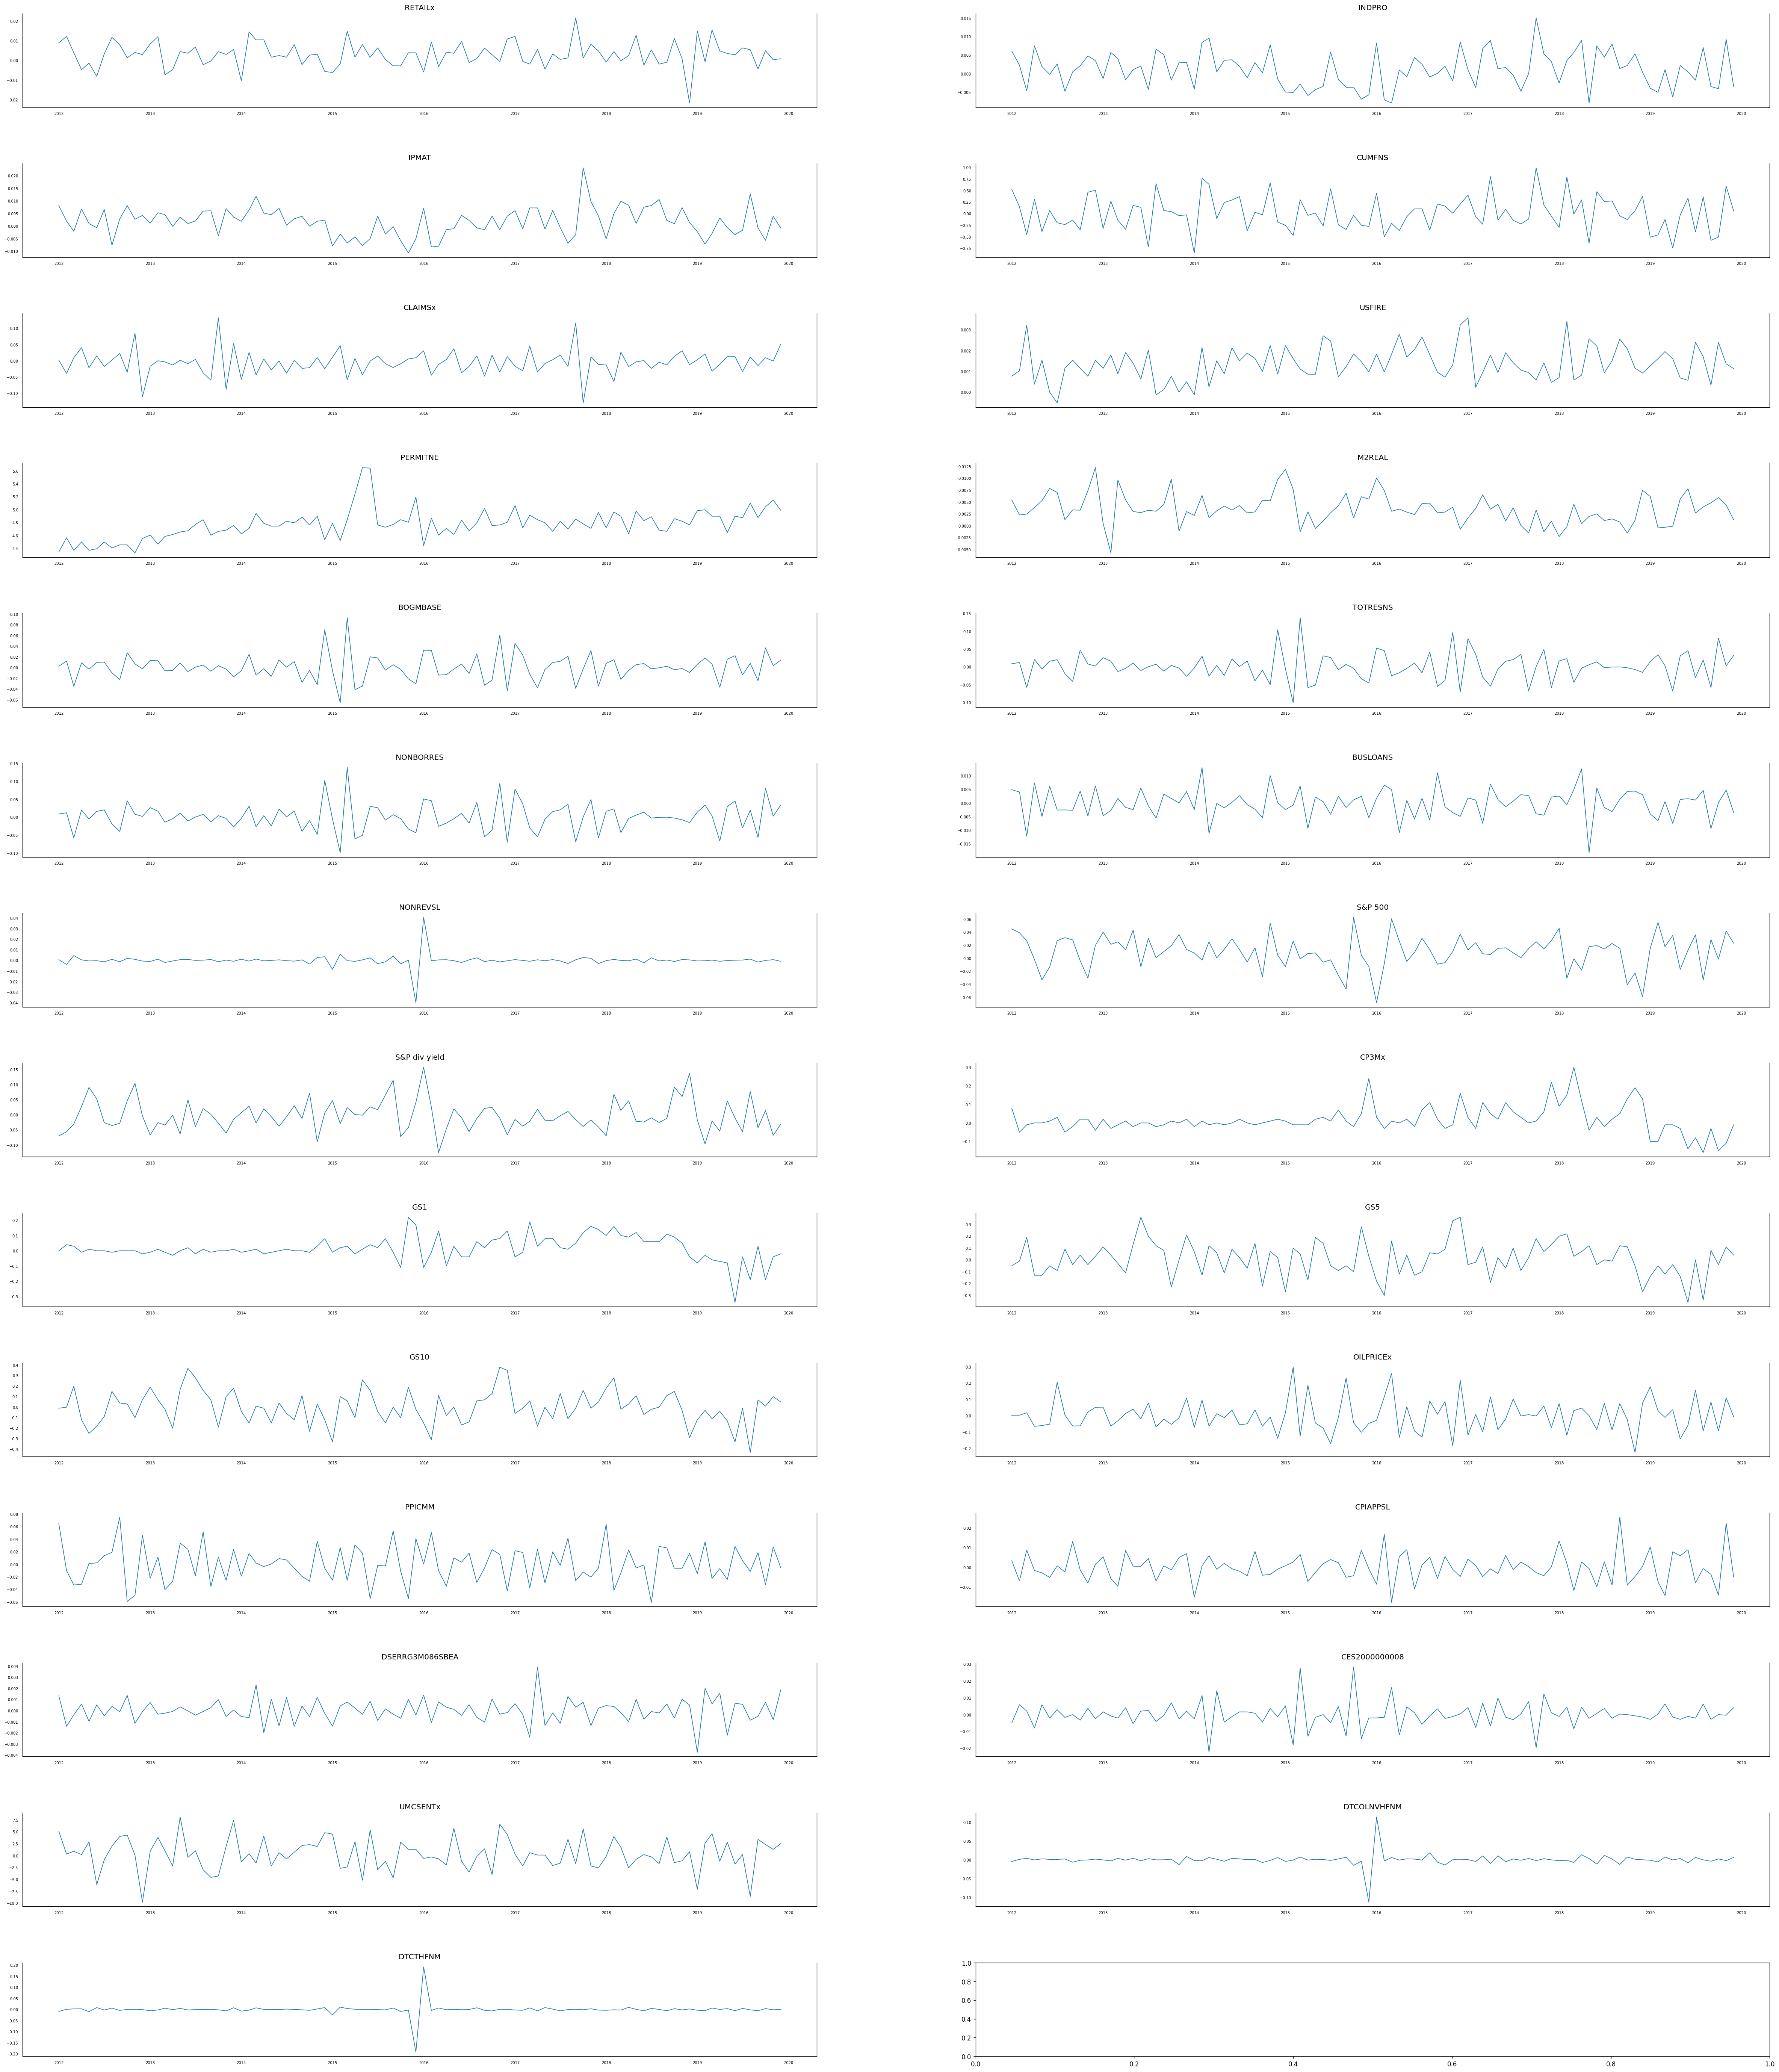

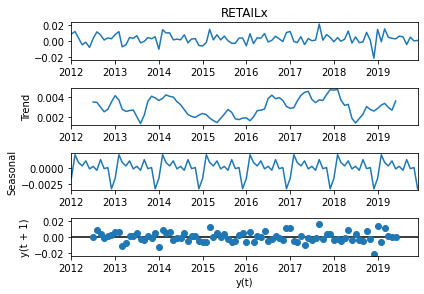

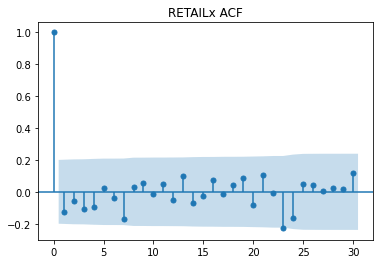

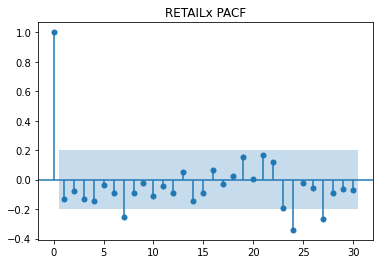

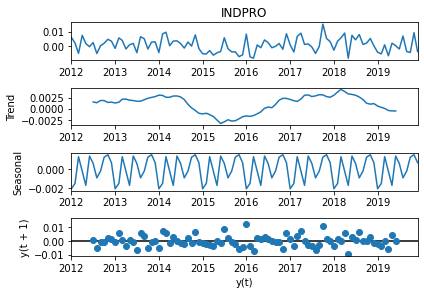

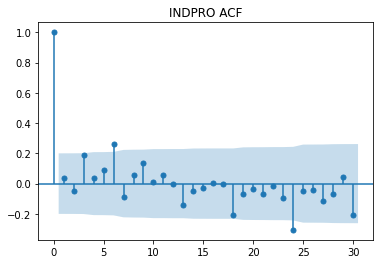

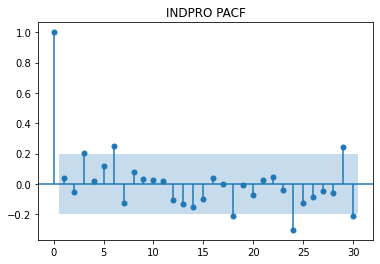

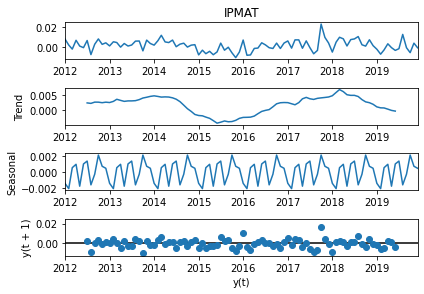

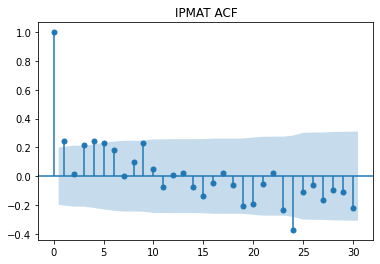

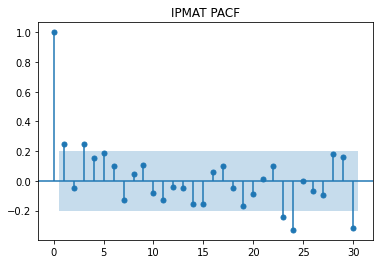

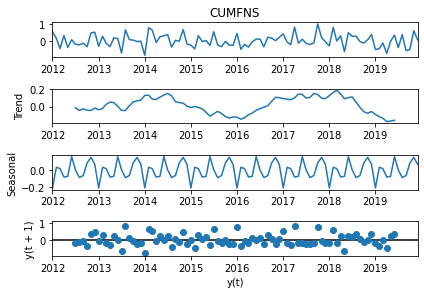

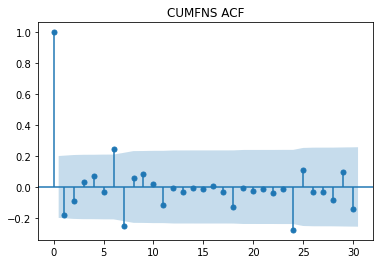

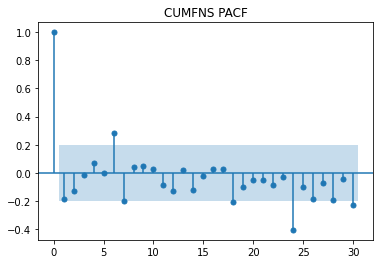

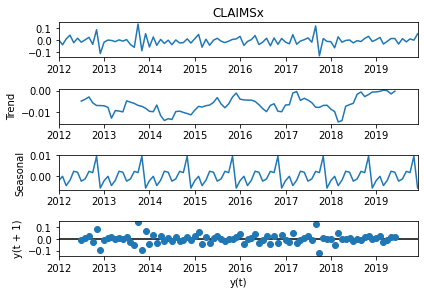

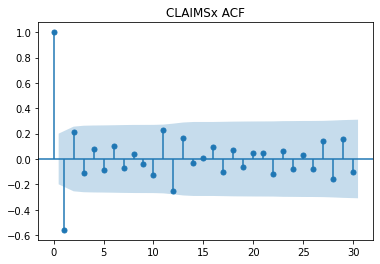

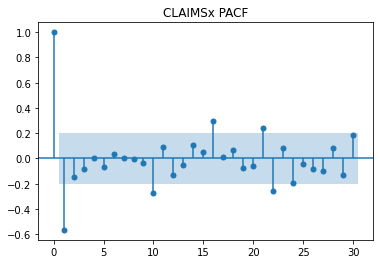

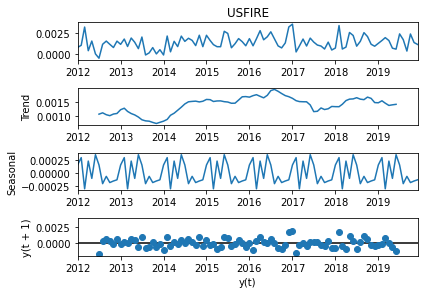

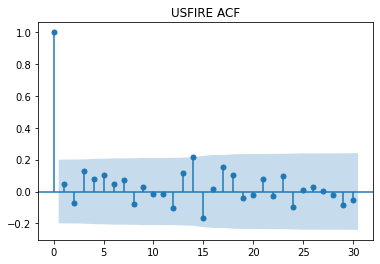

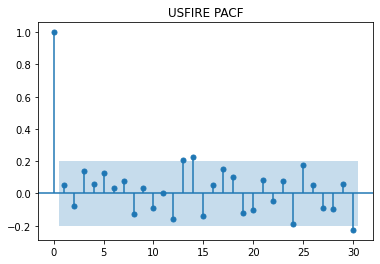

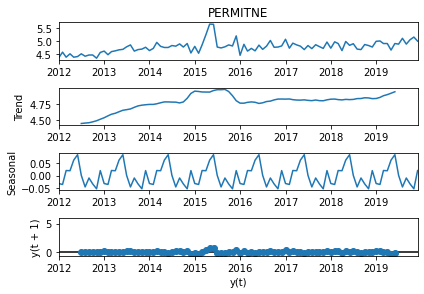

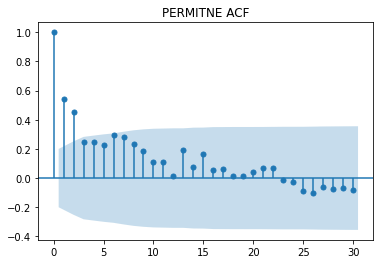

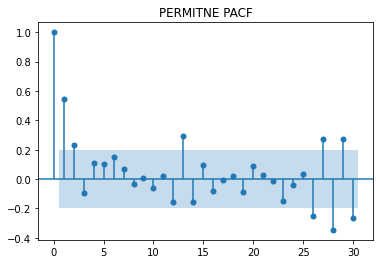

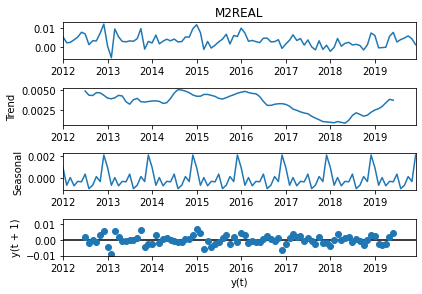

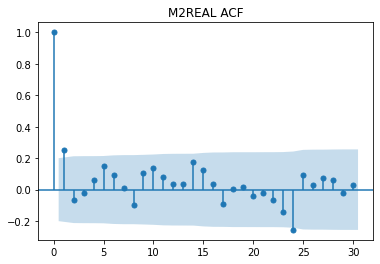

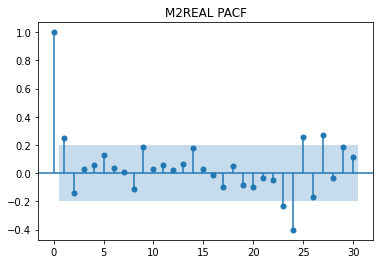

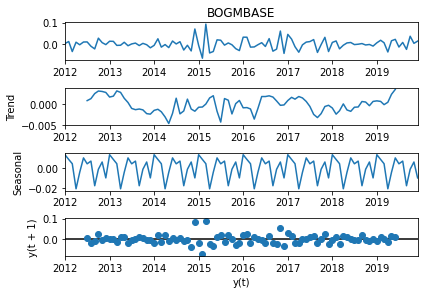

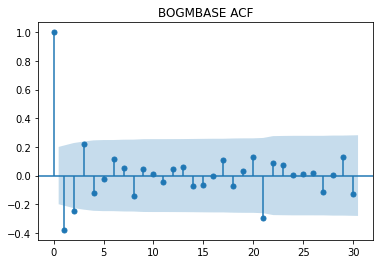

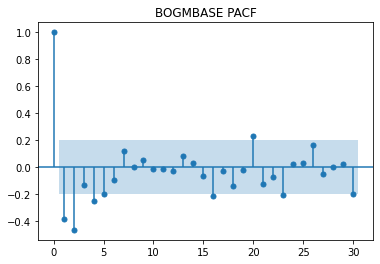

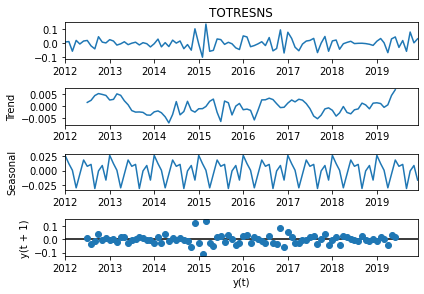

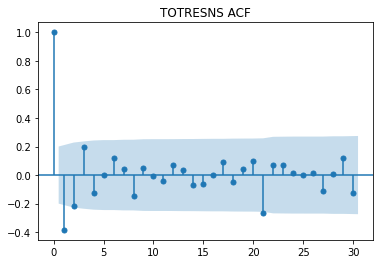

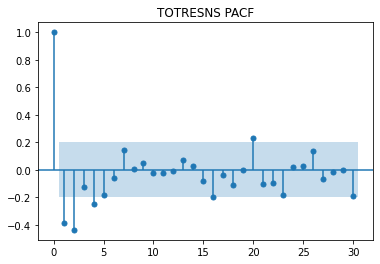

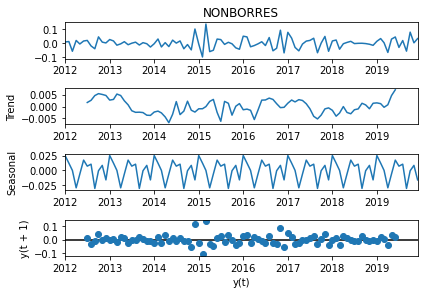

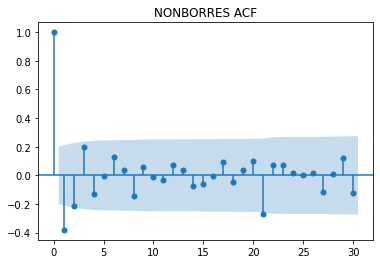

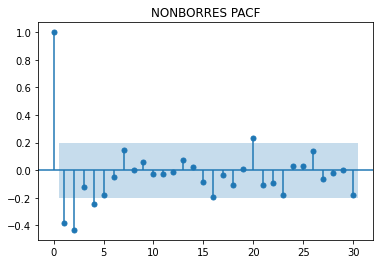

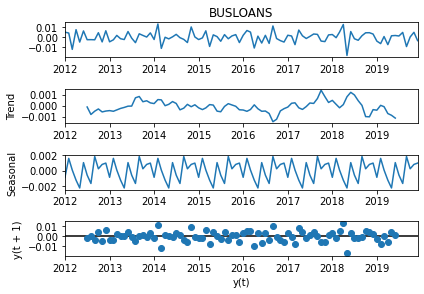

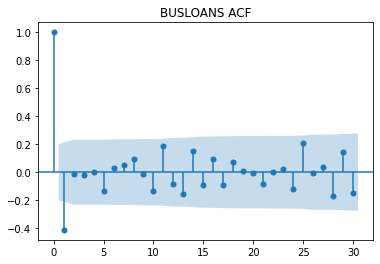

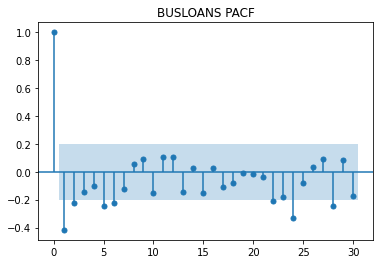

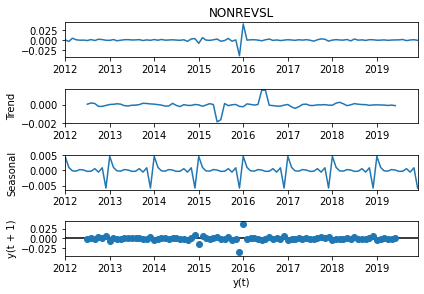

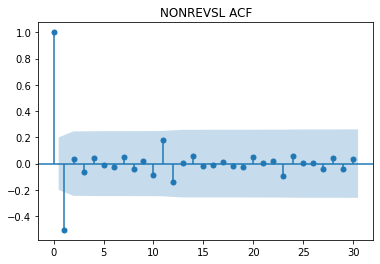

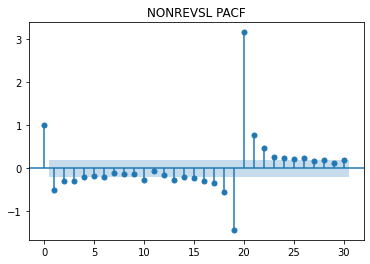

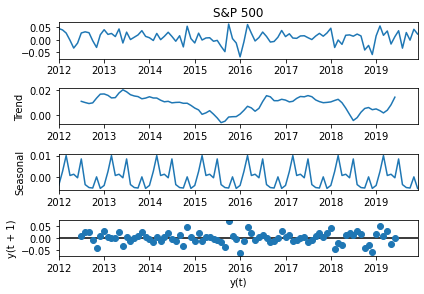

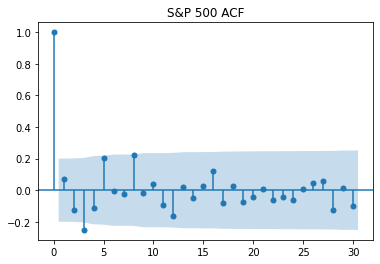

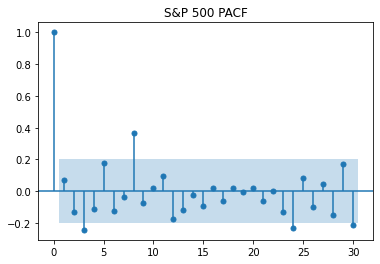

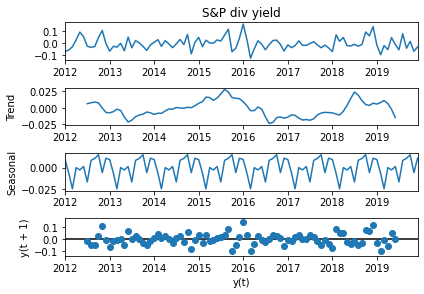

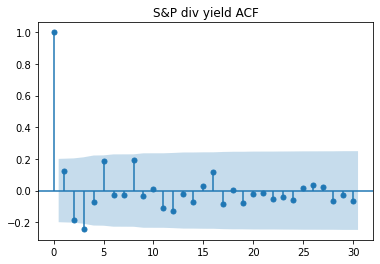

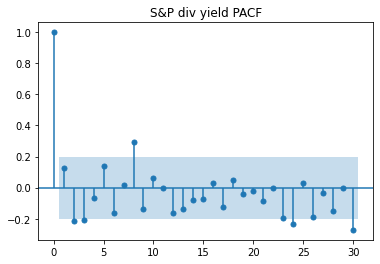

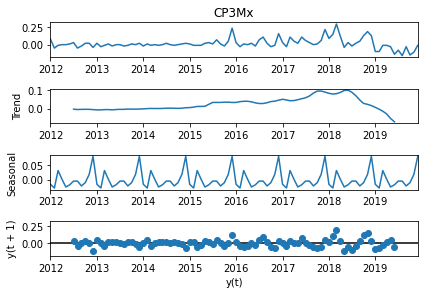

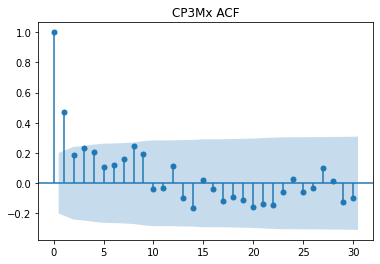

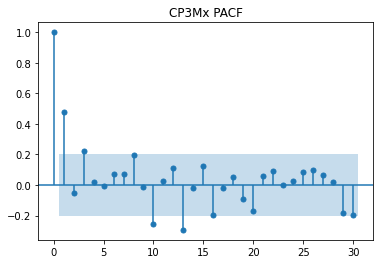

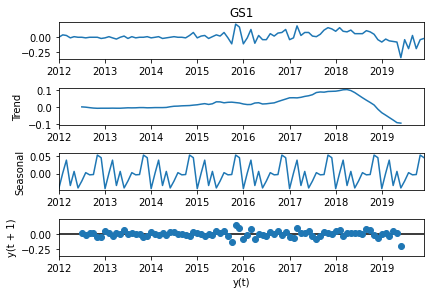

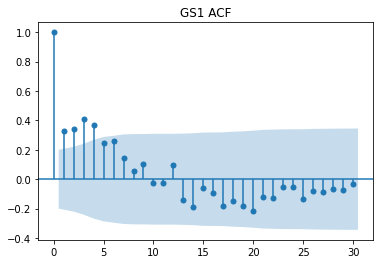

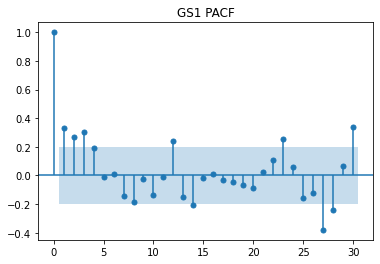

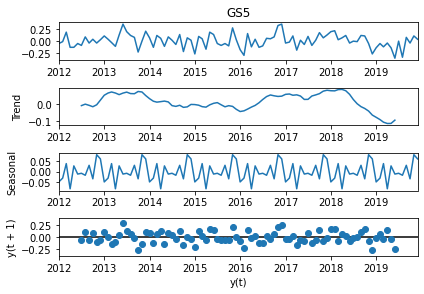

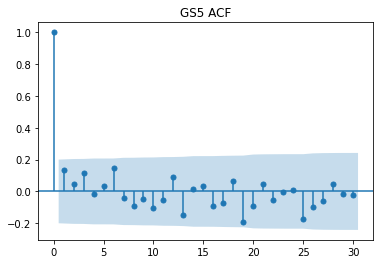

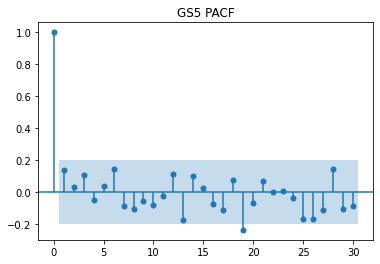

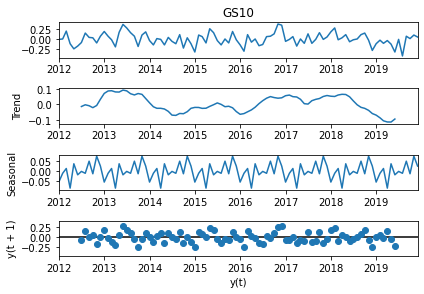

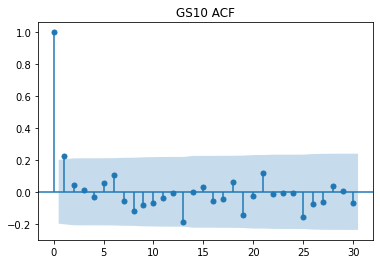

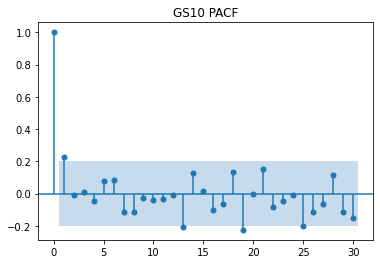

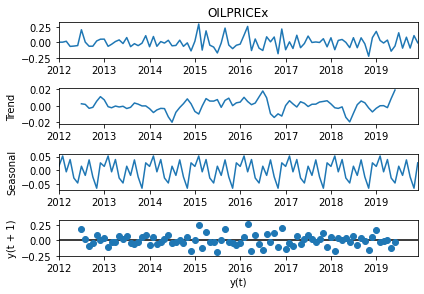

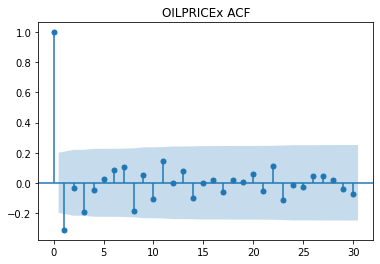

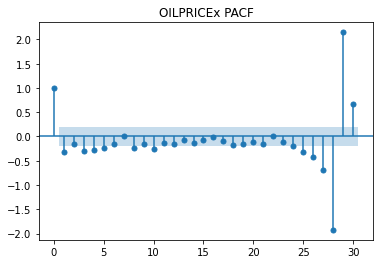

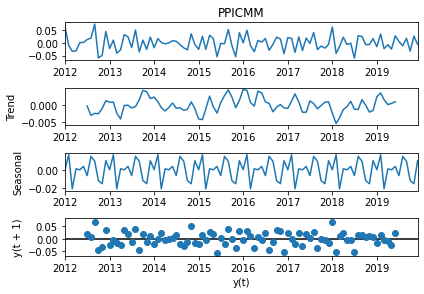

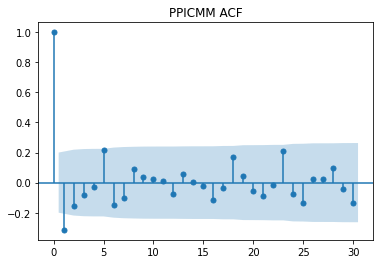

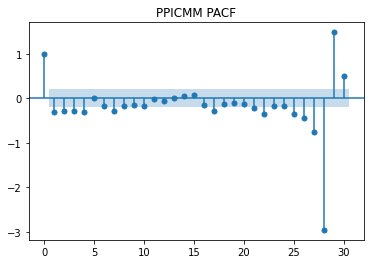

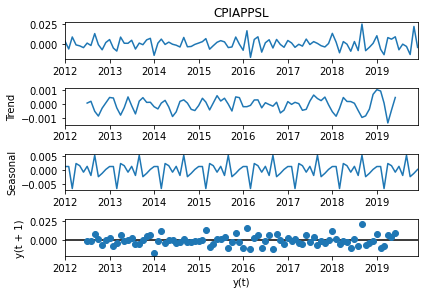

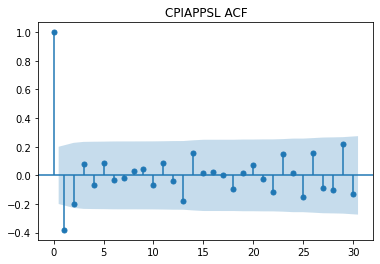

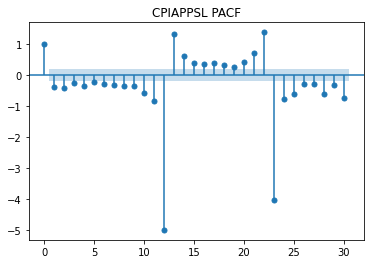

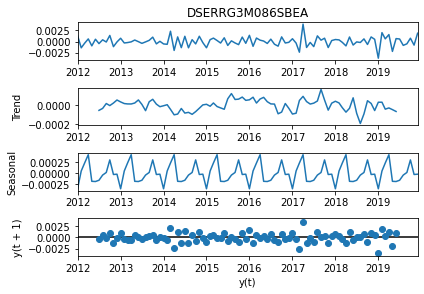

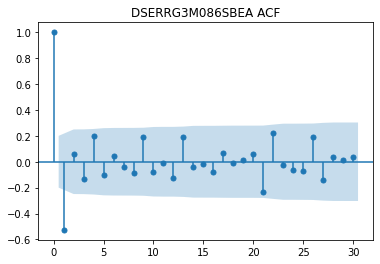

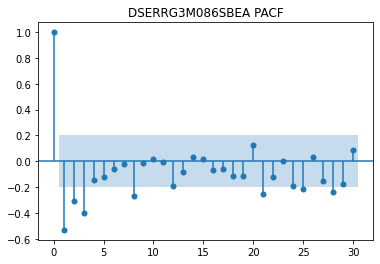

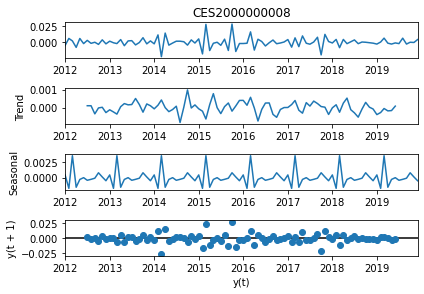

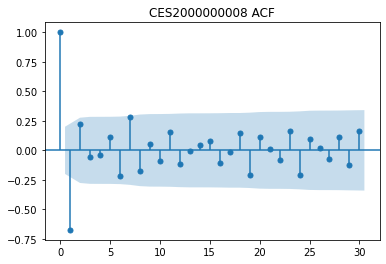

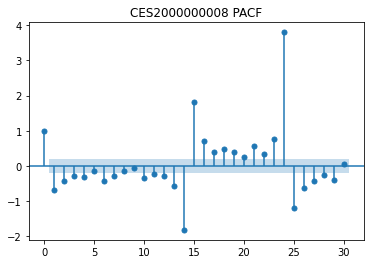

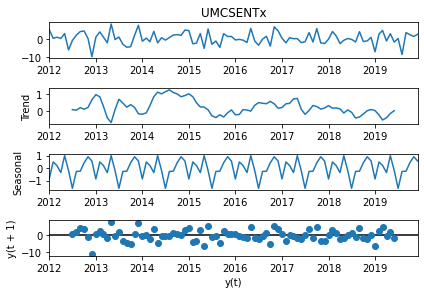

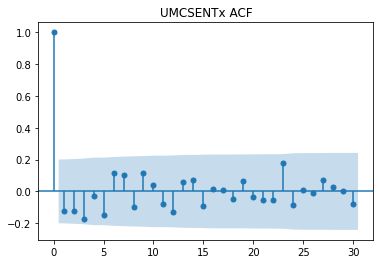

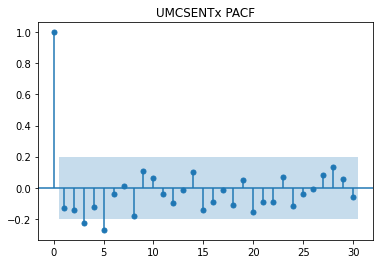

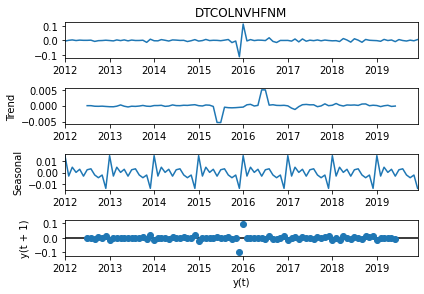

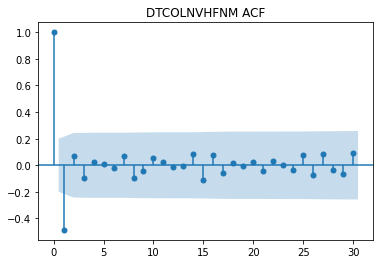

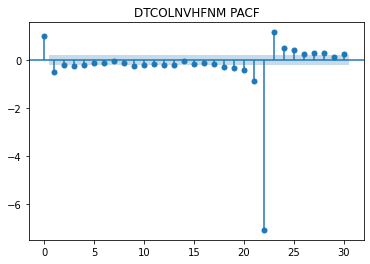

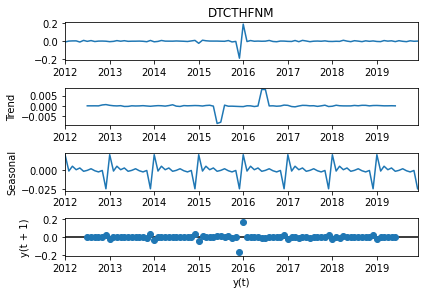

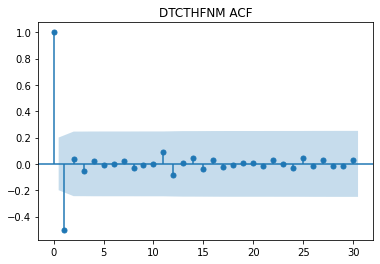

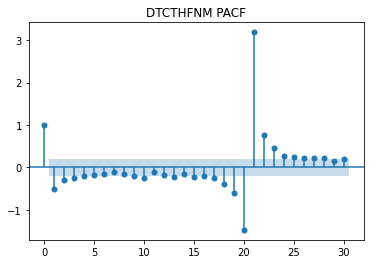

In [16]:
all_plot(df[selected_variables],season = True, acf = True,figsize = (50,60))
# どれもseasonalが発生していることがわかるので，m = 12でどこかで調整したい．

In [5]:
def adjust_data(data,dic):
    """
    Create a function to change data based on tranformation code and return a new dataframe.
    The transformation code is obtained from FRED-MD.
    THe meaning of transformation code is written below
    (1) no transformation
    (2) delta x_t
    (3) delta^2 x_t
    (4) log(x_t)
    (5) delta(log(x_t))
    (6) delta^2(log(x_t))
    (7)delta(x_t/x_{t-1} - 1)
    """
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    # change the data at each column, and add it to the new dataframe
    for key, val in dic.items():
        # if the code is 1, no transformation is required
        if val == 1:
            new_data[key] = data[key]
    
        # if the code is 2, the data needs one differentiation
        if val == 2:
            new_data[key] = data[key].diff()

        # if the code is 3, the data needs differentiation twice
        if val == 3:
            new_data[key] = data[key].diff().diff()

        # if the code is 4, the data needs to take its logarithm
        if val == 4:
            new_data[key] = data[key].apply(np.log)

        # if the code is 5, the data needs to take its logarithm and differntiation once
        if val == 5:
            new_data[key] = data[key].apply(np.log).diff()
        
        # if the code is 6, the data needs to take its rogarithm and differentiation twice
        if val == 6:
            new_data[key] = data[key].apply(np.log).diff().diff()
        
        # if the code is 7, the data needs to be divided by its lag-1 value and minus one, and then take its differentiation
        if val == 7:
            new_data[key] = data[key].dropna().pct_change().diff()
    return new_data.dropna()

def revert_forecast(forecast,dic):
    """
    This function aims to reverse the forecasted data to the original one.
    The function requires the transformation code as well
    """
    

def roop_adf(data,title = ""):
    stationary = []
    for col in data.columns:
        result = adf_test(data[col])
        if result > 0.05:
            stationary.append(col)
    return stationary

In [6]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    時系列を投入し，オプションでタイトルを決めると，ADFレポートを返す
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # はnumberの略
    out = pd.Series(result[0:4],index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() は "dtype:float64"を取り除く

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#ここからadfなどもして前期との相関を見てくれる関数を作る
def plot_series(series, figsize = (9,6), title = "", model = "add"):
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (12,9),model = "add", season = False, acf = False ,num = 30,col = 2):
    """
    全てのデータをプロットする．オプションでacf, pacfもプロットできるはず
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=0.6)
    for column in columns:
        if season == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)


#何個のdiffを取るべきかを明らかにする
def auto_adf(data):
    num = len(data.columns)
    #num_dic shows how many times the series need to be differenced
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑
#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    return df_forecast.dropna()

#granger causalityを調べる関数が必要である．
# original data でgrnger causalityを調べたとして，それはdifferenced dataに対しても有効になるのか？
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#共和分のテスト
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


#二つのデータをプロットして比較してくれる関数
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

#基のデータに戻していくプロセスを行う
def reverse_data(original_data, num = 5, order = 7):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
    return new_data.dropna()

#プロットして比較する．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)

# Evaluate関数
#予測するための道具を出す．
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_data(data,col = 2, num = 5, order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = reverse_data(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

def Durbin_Watson(data,num = 5,order = 7):
    """
    Durbin_Watson検定を行う．その際には，differencingしたデータでmin AICとなるモデルを選択して当てはめる．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))

In [7]:
# differencingしないパターンでの関数を作成した
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    return df_forecast
def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

# no_diffの場合
def Durbin_Watson_nodiff(data,num = 5,order = 7):
    """
    ダービンワトソン検定をdifferencingなしで行う．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))